In [32]:
import folium
import requests
import pandas as pd
from bs4 import BeautifulSoup
from os.path import exists
import osmnx as ox
import swifter
import ast
from itertools import combinations
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
extra_buildings = {
    "BCN": "Art Institute of Boston Library",
    "HOU": "72 East Concord Street",
    "OSW": "1 Silber Way",
    "INS": "72 East Concord Street",
    "EVN": "72 East Concord Street",
    "BAB": "300 Babcock Street",
    "ALB": "670 Albany Street",
    "XBG": "Evans Biomedical Research Center",
    "GDS": "635 Albany Street",
    "ABG": "72 East Concord Street",
    "CTC": "801 Massachusetts Avenue",
    "FPH": "37 Pilgrim Road",
}

In [21]:
def get_building_codes_data():
    if (exists("building_codes.csv")):
        return pd.read_csv("building_codes.csv")
    else:
        response = requests.get("https://www.bu.edu/summer/summer-sessions/life-at-bu/campus-resources/building-codes/")
        if response.status_code == 200:
            html_content = response.text
        else:
            raise ("Unable to access the building codes webpage")

        soup = BeautifulSoup(html_content, "html.parser")
        table = soup.find("table")
        if not table:
            print("No table found on this page")
            return None

        table_data = []
        for row in table.find_all("tr"):
            cells = row.find_all(["td", "th"])
            row_data = [cell.get_text(strip=True) for cell in cells]
            table_data.append(row_data)

        df = pd.DataFrame(table_data[1:], columns=table_data[0])
        df.columns = df.columns.str.lower()
        
        extra_df = pd.DataFrame({
            'abbreviation': list(extra_buildings.keys()),
            'address': list(extra_buildings.values())
        })
        extra_df['description'] = extra_df['abbreviation']
        
        df = pd.concat([df, extra_df], ignore_index=True)
        df = df.sort_values(by='abbreviation')
        df.to_csv("building_codes.csv", index=False)
        return df

In [22]:
address_overwrite = {
    "64–72–86 Cummington Mall": "64 Cummington Mall, Boston, Massachusetts, USA",
    "Charles River, behind BU Bridge": "Boston University Sailing Pavilion, Boston, Massachusetts, USA",
    "590–596 Commonwealth Avenue": "Metcalf Science Center, Boston, Massachusetts, USA",
    "6–8 St. Mary’s Street": "22 Babbitt Street, Boston, Massachusetts, USA",
    "715 Albany Street": "B.U. School of Public Health, Boston, Massachusetts, USA",
    "635 Albany Street": "Goldman School of Dental Medicine, Boston, Massachusetts, USA",
    "72 East Concord Street": "B.U. School of Medicine Instructional Building, Boston, Massachusetts, USA",
    "138 Mountfort Street": "138 Mountfort Street, Brookline, Norfolk County, Massachusetts, USA",
    "264–270 Bay State Road": "264 Bay State Road, Boston, Massachusetts, USA",
    "96–100 Cummington Mall": "96 Cummington Mall, Boston, Massachusetts, USA",
    "890 Commonwealth Avenue": "888 Commonwealth Avenue, Boston, Massachusetts, USA",
    "900 Commonwealth Avenue": "900 Commonwealth Avenue, Brookline, Massachusetts, USA",
    "30–38 Cummington Mall": "30 Cummington Mall, Boston, Massachusetts, USA",
    "110–112 Cummington Mall": (42.349106, -71.105177)
}


In [23]:
def convert_to_tuple(location_str):
    return ast.literal_eval(location_str)

def get_location_from_address(address: str):
    if (exists("location_from_address.csv")):
        cache = pd.read_csv("location_from_address.csv", converters={'location': convert_to_tuple})
    else:
        cache = pd.DataFrame(columns=['address', 'location'])
        
    if address in cache['address'].values:
        location = cache.loc[cache['address'] == address, 'location'].values[0]
        return location
    else:
        if address in address_overwrite:
            if isinstance(address_overwrite[address], tuple):
                location = address_overwrite[address]
                print(f"Manually assign location to {address}")
            else:
                location = ox.geocode(address_overwrite[address])
                print(f"Finding {address} with an alternative address")
        else:
            try:
                location = ox.geocode(f"{address}, Boston, Massachusetts, USA")
            except:
                try:
                    print(f"Cannot find {address} in Boston, now finding it in Cambridge")
                    location = ox.geocode(f"{address}, Cambridge, Massachusetts, USA")
                except:
                    print(f"Cannot find {address} in Boston and Cambridge, now finding it in Brookline")
                    location = ox.geocode(f"{address}, Brookline, Massachusetts, USA")

        cache.loc[len(cache)] = [address, location]
        cache.to_csv("location_from_address.csv", index=False)
        return location

def append_building_locations_data(building_codes_data: pd.DataFrame):
    building_codes_data["location"] = building_codes_data["address"].swifter.apply(get_location_from_address)
    return building_codes_data

In [24]:
def add_marker_to_map(folium_map: folium.map, location: tuple, name: str, address: str):
    folium.Marker(
    location=location,
    tooltip=name,
    popup=address,
    icon=folium.Icon(icon="book"),).add_to(folium_map)

def add_markers_to_map(folium_map: folium.map, append_building_locations_data: pd.DataFrame):
    append_building_locations_data.apply(lambda row: add_marker_to_map(folium_map, row['location'], row['description'], row['address']), axis=1)
    

In [25]:
center_location = (42.350421499999996,-71.10322831831216)
folium_map = folium.Map(location=center_location, zoom_start=16)
df = append_building_locations_data(get_building_codes_data())
add_markers_to_map(folium_map,df)

Pandas Apply:   0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
folium_map.save("map.html")
folium_map

In [27]:
graph = ox.graph_from_point(center_location, dist=6000, network_type='walk') 

In [28]:
def get_walking_distance(pointA: tuple, pointB: tuple, graph: ox.graph):
    if (exists("p2p_walking_distance.csv")):
        cache = pd.read_csv("p2p_walking_distance.csv", converters={
                            'pointA': convert_to_tuple, 'pointB': convert_to_tuple})
        pair_exists = (
            ((cache['pointA'] == pointA) & (cache['pointB'] == pointB)).any() or
            ((cache['pointA'] == pointB) & (cache['pointB'] == pointA)).any())
        if pair_exists:
            distance = cache.loc[((cache['pointA'] == pointA) & (cache['pointB'] == pointB)) | (
                (cache['pointA'] == pointB) & (cache['pointB'] == pointA)), 'distance'].values[0]
            if not pd.isna(distance):
                return distance
    orig_node = ox.distance.nearest_nodes(graph, pointA[1], pointA[0])
    dest_node = ox.distance.nearest_nodes(graph, pointB[1], pointB[0])
    shortest_path = ox.shortest_path(
        graph, orig_node, dest_node, weight='length')
    distance = sum(ox.utils_graph.get_route_edge_attributes(
        graph, shortest_path, 'length'))
    return distance


def draw_shortest_path(folium_map: folium.map, pointA: tuple, pointB: tuple, graph: ox.graph):
    orig_node = ox.distance.nearest_nodes(graph, pointA[1], pointA[0])
    dest_node = ox.distance.nearest_nodes(graph, pointB[1], pointB[0])
    shortest_path = ox.shortest_path(
        graph, orig_node, dest_node, weight='length')
    folium.PolyLine(locations=[(graph.nodes[node]['y'], graph.nodes[node]['x'])
                    for node in shortest_path], color='blue', weight=5, opacity=0.7).add_to(folium_map)


def draw_shortest_path_between_building(folium_map: folium.map, abbreviationA: str, abbreviationB: str, graph: ox.graph):
    pointA = df[df['abbreviation'] == abbreviationA]['location'].values[0]
    pointB = df[df['abbreviation'] == abbreviationB]['location'].values[0]
    draw_shortest_path(folium_map, pointA, pointB, graph)

In [33]:
# Draw the shortest path between LAW and other buildings
law_location = df[df['abbreviation'] == 'LAW']['location'].values[0]
path_to_law_map = folium.Map(location=folium_map.location, zoom_start=folium_map.options['zoom'])
add_markers_to_map(path_to_law_map, df[df['abbreviation'] != 'LAW'])
folium.Marker(
    location=law_location,
    tooltip='LAW',
    popup='LAW',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(path_to_law_map)
for index, row in df.iterrows():
    draw_shortest_path(path_to_law_map, row['location'], law_location, graph)
path_to_law_map.save("path_to_law_map.html")
path_to_law_map

In [ ]:
def calculate_distance(pair, graph: ox.graph):
    (i, row1), (j, row2) = pair
    pointA = row1['location']
    pointB = row2['location']
    distance = get_walking_distance(pointA, pointB, graph)
    return {
        'abbreviationA': row1['abbreviation'],
        'abbreviationB': row2['abbreviation'],
        'pointA': pointA,
        'pointB': pointB,
        'distance': distance
    }

def calculate_b2b_distances(append_building_locations_data: pd.DataFrame, graph: ox.graph):
    new_data = []

    if exists("b2b_walking_distance.csv"):
        b2b_cache = pd.read_csv("b2b_walking_distance.csv")
    else:
        b2b_cache = pd.DataFrame(columns=['abbreviationA', 'abbreviationB', 'distance'])
    
    existing_pairs = existing_pairs = list(zip(b2b_cache[b2b_cache['distance'].notnull()]['abbreviationA'],
                              b2b_cache[b2b_cache['distance'].notnull()]['abbreviationB']))
    pairs = list(combinations(append_building_locations_data.iterrows(), 2))
    new_pairs = []

    for pair in pairs:
        (i, row1), (j, row2) = pair
        abbreviationA = row1['abbreviation']
        abbreviationB = row2['abbreviation']
        if (abbreviationA, abbreviationB) not in existing_pairs and (abbreviationB, abbreviationA) not in existing_pairs:
            new_pairs.append(pair)
            
    total_pairs = len(new_pairs)
    
    with ThreadPoolExecutor() as executor:
        for result in tqdm(executor.map(lambda pair: calculate_distance(pair, graph), new_pairs), total=total_pairs, desc='B2B Distance calculation'):
            new_data.append(result)
            
    if (exists("p2p_walking_distance.csv")):
        p2p_cache = pd.read_csv("p2p_walking_distance.csv", converters={'pointA': convert_to_tuple, 'pointB': convert_to_tuple})
    else:
        p2p_cache = pd.DataFrame(columns=['pointA', 'pointB', 'distance'])
        
    if (exists("b2b_walking_distance.csv")):
        b2b_cache = pd.read_csv("b2b_walking_distance.csv")
    else:
        b2b_cache = pd.DataFrame(columns=['abbreviationA', 'abbreviationB', 'distance'])
    
    if len(new_data) > 0:
        new_df = pd.DataFrame(new_data)
        p2p_cache = pd.concat([p2p_cache, new_df[['pointA', 'pointB', 'distance']]]).drop_duplicates()
        p2p_cache.to_csv("p2p_walking_distance.csv", index=False)

        b2b_cache = pd.concat([b2b_cache, new_df[['abbreviationA', 'abbreviationB', 'distance']]]).drop_duplicates()
        b2b_cache.to_csv("b2b_walking_distance.csv", index=False)
    
    target = []
    for pair in pairs:
        (i, row1), (j, row2) = pair
        target.append({
        'abbreviationA': row1['abbreviation'],
        'abbreviationB': row2['abbreviation'],
    })
        target.append({
        'abbreviationA': row2['abbreviation'],
        'abbreviationB': row1['abbreviation'],
    })
    target_df = pd.DataFrame(target)
    
    return pd.merge(target_df, b2b_cache, on=['abbreviationA', 'abbreviationB'], how='inner')

In [ ]:
calculate_b2b_distances(df, graph)


B2B Distance calculation: 100%|██████████| 4005/4005 [2:15:01<00:00,  2.02s/it]


abbreviationA abbreviationB  distance
0              AAS           ABG  3712.206
1              AAS           AGG  1093.251
2              AAS           ALB  3968.326
3              AAS           ASC  1630.178
4              AAS           BAB  1630.178
...            ...           ...       ...
4000           WEA           XBG  3348.447
4001           WEA           YAW   296.011
4002           WED           XBG  3255.361
4003           WED           YAW   273.509
4004           XBG           YAW  3052.436

[4005 rows x 3 columns]

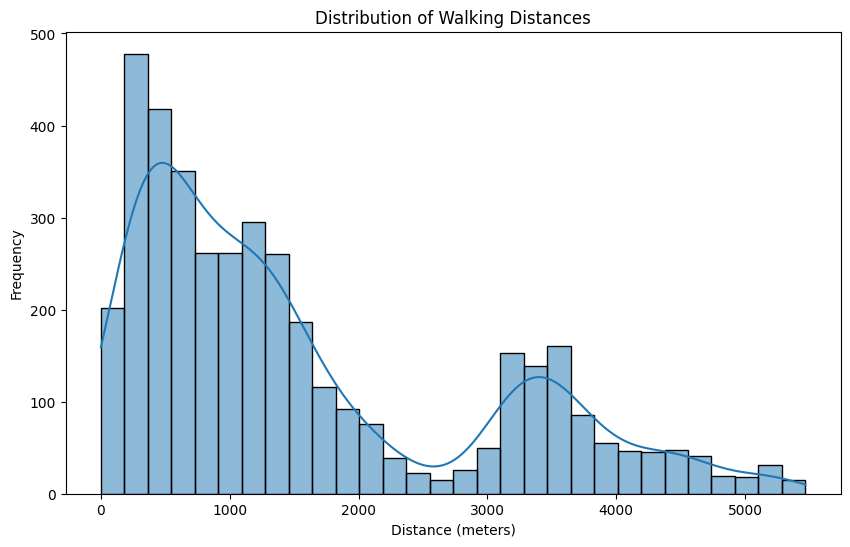

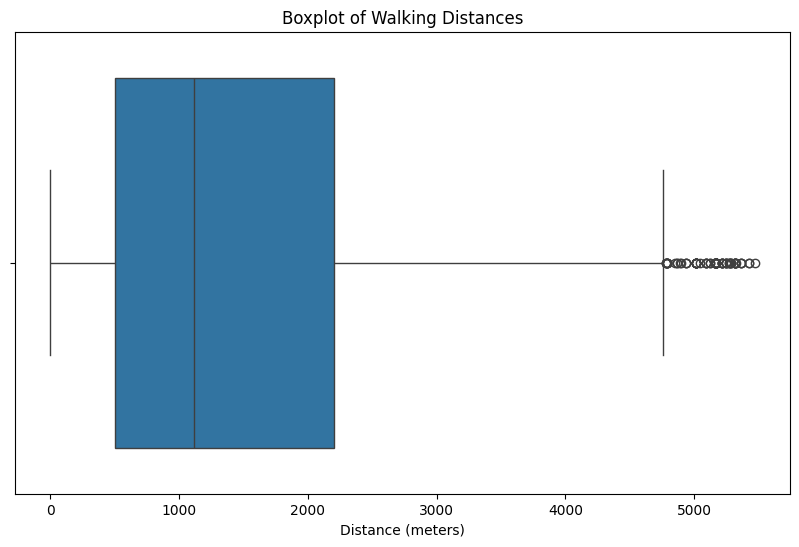

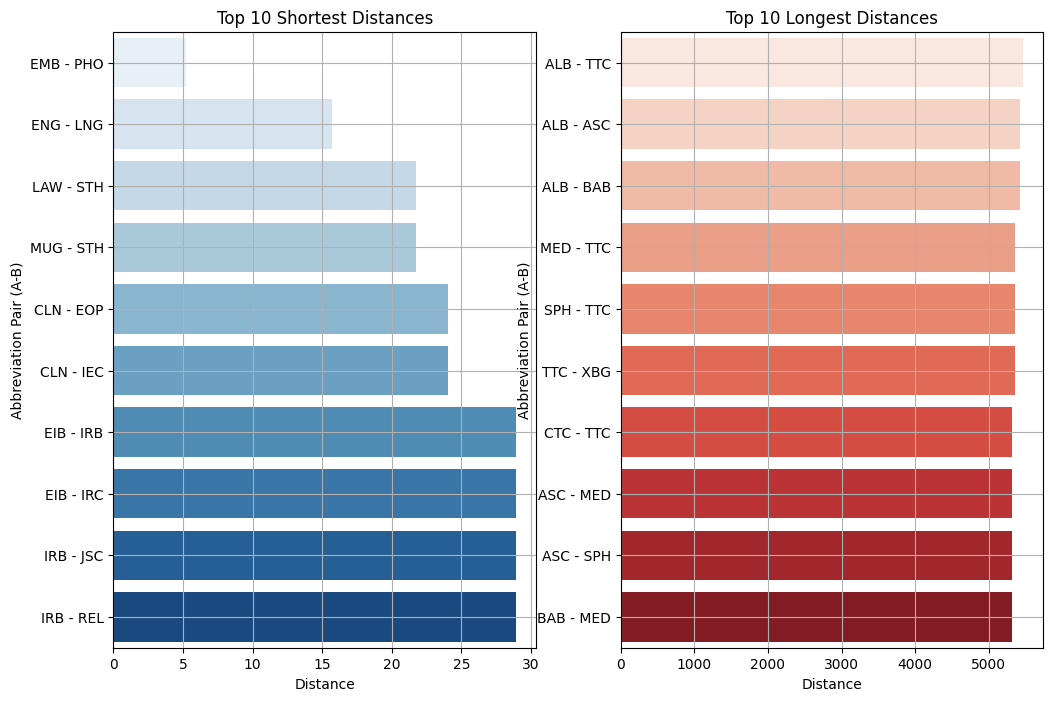

In [40]:
# Read the b2b_walking_distance.csv file
b2b_df = pd.read_csv("b2b_walking_distance.csv")

# Plot the distribution of walking distances
plt.figure(figsize=(10, 6))
sns.histplot(b2b_df['distance'], bins=30, kde=True)
plt.title('Distribution of Walking Distances')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.savefig('distribution_of_walking_distances.png')
plt.show()

# Plot the boxplot of walking distances
plt.figure(figsize=(10, 6))
sns.boxplot(x=b2b_df['distance'])
plt.title('Boxplot of Walking Distances')
plt.xlabel('Distance (meters)')
plt.savefig('boxplot_of_walking_distances.png')
plt.show()

# Get the shortest and longest 10 distances
shortest_10 = b2b_df[b2b_df["distance"] != 0].nsmallest(10, 'distance')
longest_10 = b2b_df.nlargest(10, 'distance')

# Plot the top 10 shortest and longest distances
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.barplot(x='distance', y=shortest_10.apply(lambda row: f"{row['abbreviationA']} - {row['abbreviationB']}", axis=1), data=shortest_10, palette='Blues')
plt.title('Top 10 Shortest Distances')
plt.xlabel('Distance')
plt.ylabel('Abbreviation Pair (A-B)')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.barplot(x='distance', y=longest_10.apply(lambda row: f"{row['abbreviationA']} - {row['abbreviationB']}", axis=1), data=longest_10, palette='Reds')
plt.title('Top 10 Longest Distances')
plt.xlabel('Distance')
plt.ylabel('Abbreviation Pair (A-B)')
plt.grid(True)

plt.savefig('top_10_distances.png')
plt.show()

# Plot the heatmap of walking distances between buildings
pivot_table = b2b_df.pivot(index='abbreviationA', columns='abbreviationB', values='distance')
plt.figure(figsize=(120, 100))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".1f", linewidths=.5)
plt.title('Heatmap of Walking Distances Between Buildings')
plt.xlabel('Building B')
plt.ylabel('Building A')
plt.savefig('heatmap_of_walking_distances.png')
plt.show()